# Imports/Defines



In [ ]:
from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from keras.utils import to_categorical
import tensorflow as tf
import os
print('Tensorflow version:', tf.__version__, '(Expected 2.7.0)')


# Ersetzen des 'model_name' durch den Namen Ihres Modells
model_name = 'marvin'
# Ersetzen des'checkpoint' durch den gewünschten Checkpoint-Dateinamen
checkpoint_filename = 'marvin.h5'
# Der vollständige Pfad zur Checkpoint-Datei
checkpoint_path = os.path.join('/content', model_name, checkpoint_filename)
print("Checkpoint-Dateipfad:", checkpoint_path)


# Data
Data Import, Tensorflow Covertion, Normalization, Random Label Selection, Augmentation

In [2]:

# Loading the MNIST dataset in one line

import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
x_train, y_train = [], []

for image, label in ds_train:
    x_train.append(image)
    y_train.append(label)

# Konvertieren Sie die Listen in TensorFlow-Tensoren
x_train = np.stack(x_train)
y_train = np.stack(y_train)
# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)

x_test, y_test = [], []

for image, label in ds_test:
    x_test.append(image)
    y_test.append(label)

# Convert the lists to TensorFlow Tensors
x_test = np.stack(x_test)
y_test = np.stack(y_test)

# Printing the shape
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train_normalized = x_train/255
x_test_normalized = x_test/255

# in the next step, we also need to reshape our input to fit our input layer later on.
# This is due to keras expecting a definition for how many channels your input sample has, as we
# deal with gray scale this is 1.
x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)
#Decreasing Number of Samples used

# Klassenverteilung analysieren
class_counts = np.bincount(y_train)

# Anzahl der Bilder pro Klasse, die Sie auswählen möchten (angenommen: 10000 Bilder insgesamt)
images_per_class = 10000 // len(class_counts)

# Indizes der ausgewählten Bilder
selected_indices = []

for class_label, count in enumerate(class_counts):
    # Indizes der Bilder in dieser Klasse
    class_indices = np.where(y_train == class_label)[0]

    # Zufällig auswählen, wenn es mehr Bilder gibt als benötigt
    if count <= images_per_class:
        selected_indices.extend(class_indices)
    else:
        selected_indices.extend(np.random.choice(class_indices, size=images_per_class, replace=False))

# Verwenden Sie selected_indices, um die entsprechenden Bilder zu extrahieren
x_train = x_train[selected_indices]
y_train = y_train[selected_indices]
# Adding Data Augmenatation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 90)
            zoom_range = 0.1, # Randomly zoom image
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

#fitting the ImageDataGenerator
datagen.fit(x_train)


Tensorflow version: 2.15.0 (Expected 2.7.0)
Checkpoint-Dateipfad: /content/marvin/marvin.h5


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
x_train: (60000, 28, 28, 1)
y_train: (60000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)


# Backbone
Definition of the LeNet-Backbone network

In [3]:
from tensorflow.keras import layers, models
input_shape = (28, 28, 1)
def LeNet5(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

# Main Model / Callbacks

In [12]:
# Funktion zur Erstellung des Hauptmodells mit dem LeNet-5-Modell als Unterarchitektur
def create_marvin(input_shape):

  marvin = models.Sequential()


  marvin.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='valid'))
  marvin.add(tf.keras.layers.BatchNormalization())
  marvin.add(tf.keras.layers.MaxPooling2D(pool_size=(2), strides=2, padding='valid'))
  marvin.add(tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu', padding='valid'))
  marvin.add(tf.keras.layers.BatchNormalization())
  marvin.add(tf.keras.layers.MaxPooling2D(pool_size=(2), strides=2, padding='valid' ))
  marvin.add(tf.keras.layers.Flatten())
  marvin.add(tf.keras.layers.Dropout(0.3))
  marvin.add(tf.keras.layers.Dense(10, activation='softmax'))

  return marvin


# Erstellen Sie das Hauptmodell mit dem LeNet-5-Modell als Unterarchitektur
marvin = create_marvin(input_shape)

sbo = tf.keras.callbacks.ModelCheckpoint(
      filepath = "marvin.h5",
      monitor = 'val_accuracy',
      save_best_only = True,
      save_weights_only = False,
      mode = "max",
      save_freq="epoch",)

early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Define your loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
print(-tf.math.log(1/10))
sampleID = 200
loss_fn(y_train[:1], marvin(x_train[sampleID-1:sampleID]).numpy()).numpy()
marvin.compile(optimizer='adam',
              loss= loss_fn ,
              metrics=['accuracy'])


tf.Tensor(2.3025851, shape=(), dtype=float32)


In [5]:
marvin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 26, 26, 16)           160       
                                                                 
 batch_normalization (Batch  (1, 26, 26, 16)           64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (1, 13, 13, 16)           0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (1, 11, 11, 4)            580       
                                                                 
 batch_normalization_1 (Bat  (1, 11, 11, 4)            16        
 chNormalization)                                                
                                                        

# Black/White Experiment

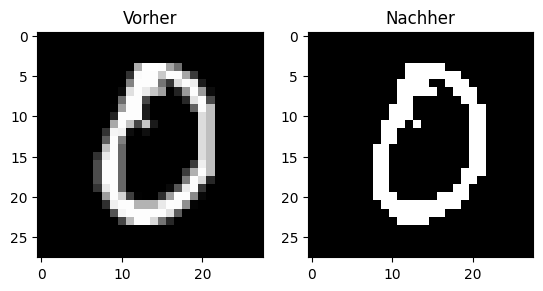

In [6]:
# Funktion zur Umwandlung in Schwarz-Weiß
def to_black_and_white(image, threshold=0.5):
    return (image > threshold).astype(np.uint8) * 255



# Wende die Funktion auf alle Bilder im Trainingsset an
x_train_bw = np.array([to_black_and_white(image) for image in x_train])
x_test_bw = np.array([to_black_and_white(image) for image in x_test])

# Zeige ein Beispielbild vorher/nachher
index = 0
plt.subplot(1, 2, 1)
plt.imshow(x_train[index], cmap='gray')
plt.title('Vorher')
plt.subplot(1, 2, 2)
plt.imshow(x_train_bw[index], cmap='gray')
plt.title('Nachher')
plt.show()

# One-Hot-Encoding

In [7]:
# Konvertiere die Klassenlabels zu One-Hot Encoding
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)
print(y_train)
print(y_train_one_hot)

[0 0 0 ... 9 9 9]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# Training

In [11]:
marvin.fit(
    x_train,
    y_train,
    epochs= 50,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[sbo, early_stopping]
)


Epoch 1/50
157/157 [==============================] - 3s 10ms/step - loss: 1.8049 - accuracy: 0.4531 - val_loss: 1.8536 - val_accuracy: 0.3164
Epoch 2/50
157/157 [==============================] - 2s 10ms/step - loss: 0.6816 - accuracy: 0.7854 - val_loss: 1.2124 - val_accuracy: 0.6730
Epoch 3/50
157/157 [==============================] - 2s 10ms/step - loss: 0.4409 - accuracy: 0.8675 - val_loss: 0.5754 - val_accuracy: 0.8675
Epoch 4/50
157/157 [==============================] - 2s 10ms/step - loss: 0.3344 - accuracy: 0.8981 - val_loss: 0.2695 - val_accuracy: 0.9313
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 0.2703 - accuracy: 0.9200 - val_loss: 0.1993 - val_accuracy: 0.9435
Epoch 6/50
157/157 [==============================] - 1s 6ms/step - loss: 0.2372 - accuracy: 0.9307 - val_loss: 0.1936 - val_accuracy: 0.9416
Epoch 7/50
157/157 [==============================] - 1s 6ms/step - loss: 0.2069 - accuracy: 0.9382 - val_loss: 0.1500 - val_accuracy: 0.9550
Ep

# Evaluation


In [12]:

# load a saved marvin configuration you want to evaluate
model_name = "marvin.h5"
marvin_reloaded = tf.keras.models.load_model(model_name)

# Let Marvin predict on the test set, so we have some data to evaluate his performance.
predictions = marvin_reloaded.predict([x_test])

# Remember that the prediction of Marvin is a probability distribution over all ten-digit classes
# We want him to assign the digit class with the highest probability to the sample.
predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)

313/313 [==============================] - 1s 2ms/step


**Plots**

<ipython-input-13-9baaff025309>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


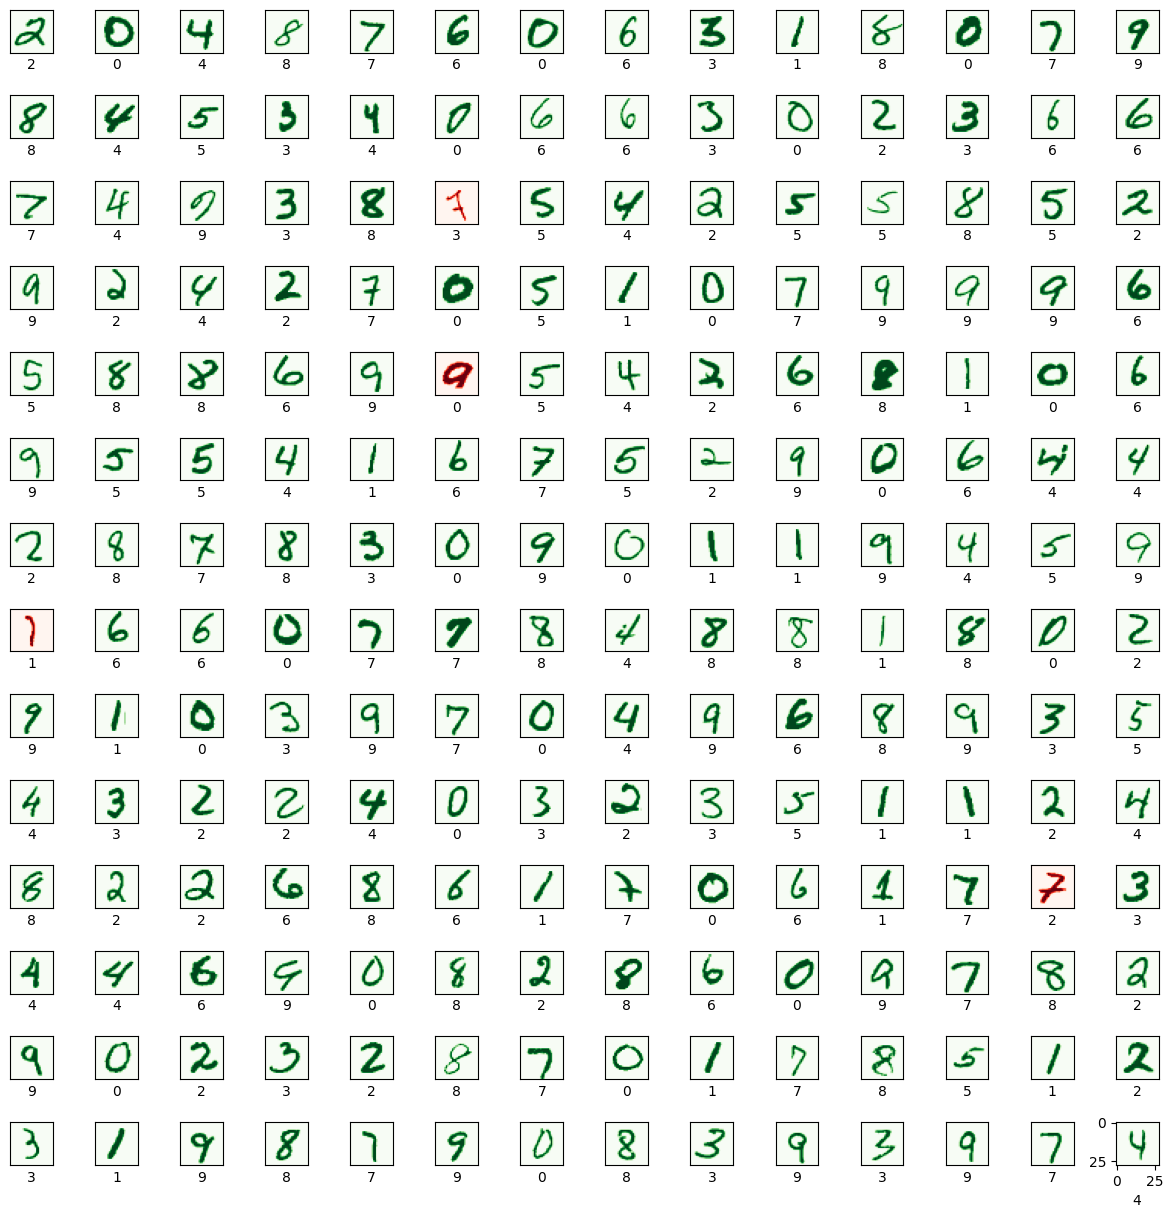

In [13]:

# Plot for the intuitive approach

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

#Confusion Matrix

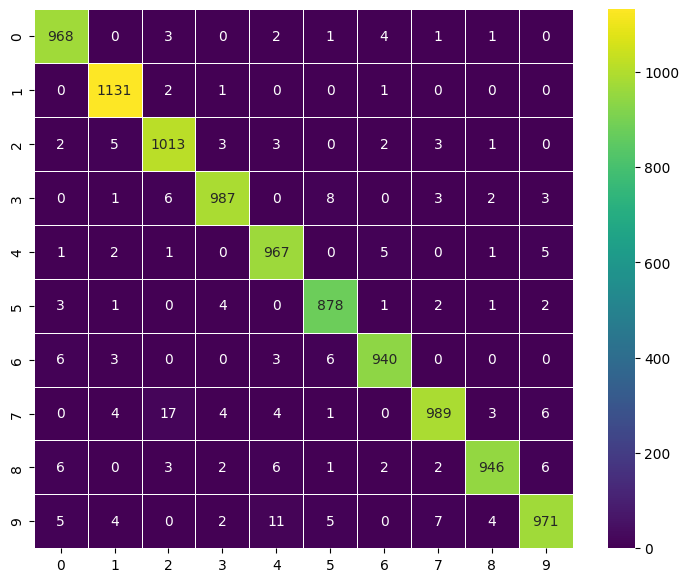

In [14]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()